In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import seaborn as sns
sns.set_theme()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import shap
import mlflow
from feature_engineering import feature_engineering
import matplotlib.pyplot as plt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [2]:
train_df, test_df = feature_engineering()

Columns (0,38,50) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
x_train_df = train_df.drop(columns=['Bat Score'])
x_test_df = test_df.drop(columns=['Bat Score'])

y_train_df = train_df['Bat Score']
y_test_df = test_df['Bat Score']

In [4]:
train_df.head()

,Bat Score,Pitch X Bins,Pitch Y Bins,Ball Speed,At Stumps X Bins,At Stumps Y Bins,Over,Movement In Air,Movement Off Pitch,MatchInnings,Match Id,Bounce Angle Delta,Ball In Over,Power Play
8036,1,18.0,23.0,87.077307,20.0,7.0,11,1.82,-3.22,1,4353016,1.49,1,0
70182,2,19.0,27.0,92.506665,19.0,6.0,6,1.84,-0.95,1,5181109,4.47,4,0
73118,1,19.0,38.0,127.843139,17.0,8.0,7,0.27,-0.50,1,5181123,4.35,3,0
125149,0,16.0,26.0,83.143581,15.0,7.0,1,1.79,-0.73,1,5460202,4.85,3,1
94907,2,12.0,43.0,133.610206,14.0,8.0,3,-0.30,0.10,2,5181534,5.68,7,1


# Model Build

In [5]:
# Create dmatrix for XGBoost
dtrain = xgb.DMatrix(x_train_df.drop(columns=['Match Id', 'Ball In Over']), y_train_df, enable_categorical=True)
dtest = xgb.DMatrix(x_test_df.drop(columns=['Match Id', 'Ball In Over']), y_test_df, enable_categorical=True)

In [8]:
# Define hyperparameters
params = {
    'objective': 'reg:squarederror'
    , 'tree_method':'auto'
    , 'eval_metric':'rmse'
    # , 'colsample_bytree': 1.0
    # , 'eta': 0.17500000000000002
    # , 'gamma': 0.55
    # , 'max_depth': 2
    # , 'min_child_weight': 5.0
    ,'max_depth': 7, 'eta': 0.015307413852226913, 'min_child_weight': 9, 'subsample': 0.72824825500041, 'colsample_bytree': 0.9500071649615968, 'reg_alpha': 9.536364391534908, 'reg_lambda': 9.984650298663272
}

n = 1000

evals = [(dtrain, "train"), (dtest, "validation")]

## Hyperparameter Tuning

## Model

In [9]:
# Run Model
model = xgb.train(
    params=params
    , dtrain=dtrain
    , num_boost_round = n
    , verbose_eval=10
    , early_stopping_rounds=50
    , evals=evals
)

best_iteration = model.best_iteration
yhat = np.clip(model.predict(dtest, iteration_range=(0, best_iteration)),a_min=0,a_max=None)

[0]	train-rmse:1.63730	validation-rmse:1.64142
[10]	train-rmse:1.63083	validation-rmse:1.63578
[20]	train-rmse:1.62551	validation-rmse:1.63121
[30]	train-rmse:1.62106	validation-rmse:1.62749
[40]	train-rmse:1.61742	validation-rmse:1.62448
[50]	train-rmse:1.61400	validation-rmse:1.62166
[60]	train-rmse:1.61111	validation-rmse:1.61948
[70]	train-rmse:1.60857	validation-rmse:1.61742
[80]	train-rmse:1.60609	validation-rmse:1.61551
[90]	train-rmse:1.60411	validation-rmse:1.61415
[100]	train-rmse:1.60235	validation-rmse:1.61289
[110]	train-rmse:1.60073	validation-rmse:1.61189
[120]	train-rmse:1.59915	validation-rmse:1.61086
[130]	train-rmse:1.59761	validation-rmse:1.60986
[140]	train-rmse:1.59613	validation-rmse:1.60892
[150]	train-rmse:1.59484	validation-rmse:1.60816
[160]	train-rmse:1.59335	validation-rmse:1.60722
[170]	train-rmse:1.59192	validation-rmse:1.60640
[180]	train-rmse:1.59063	validation-rmse:1.60566
[190]	train-rmse:1.58944	validation-rmse:1.60499
[200]	train-rmse:1.58830	valida

# Evaluation

In [10]:
yhat.sum()

43804.125

In [11]:
y_test_df.sum()

43622

In [12]:
((y_test_df.sum() - yhat.sum())/y_test_df.sum())*100

-0.41750722112695426

In [13]:
print(f'Mean: {yhat.mean()}\nSTD: {yhat.std()}\nMin: {yhat.min()}\nMax: {yhat.max()}')

Mean: 1.2733017206192017
STD: 0.389655739068985
Min: 0.0
Max: 3.6074559688568115


Text(0.5, 0, 'xR')

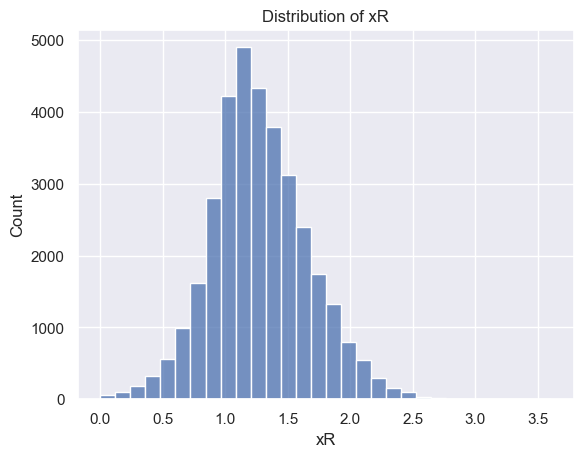

In [14]:
ax = sns.histplot(yhat,bins=30)
ax.set_title('Distribution of xR')
ax.set_xlabel('xR')

## SHAP

In [15]:
X = pd.concat([x_train_df.drop(columns=['Match Id', 'Ball In Over']),x_test_df.drop(columns=['Match Id', 'Ball In Over'])])

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [17]:
shap.initjs()

In [18]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

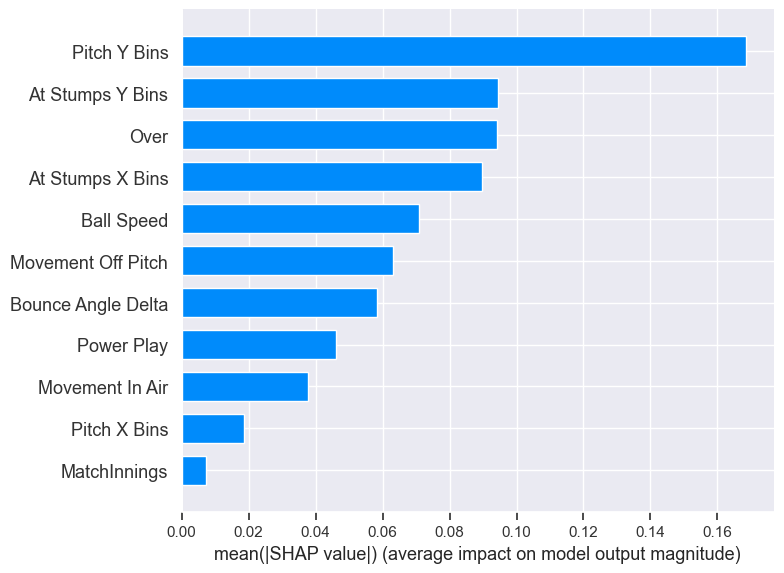

In [19]:
shap.summary_plot(shap_values, X, plot_type="bar")

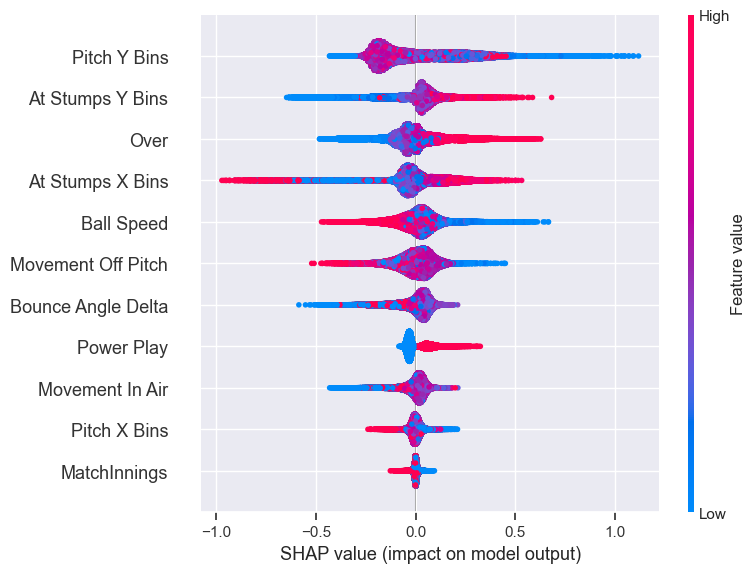

In [20]:
shap.summary_plot(shap_values, X)

## Analysis

In [38]:
df = feature_engineering('Predict')

Columns (0,38,50) have mixed types.Specify dtype option on import or set low_memory=False.


In [39]:
df.shape

(181705, 14)

In [40]:
# Create dmatrix for XGBoost
dpredict = xgb.DMatrix(df.drop(columns=['Match Id', 'Ball In Over','Bat Score']), df['Bat Score'], enable_categorical=True)

In [41]:
yhat = np.clip(model.predict(dpredict, iteration_range=(0, best_iteration)),a_min=0,a_max=None)

In [42]:
df['xr'] = yhat

In [43]:
df_actual = pd.read_csv(r'C:\Users\anude\Desktop\Jupyter Notebook Projects\Cricket NSW\Data\T20M BBB - latest.csv')

Columns (0,38,50) have mixed types.Specify dtype option on import or set low_memory=False.


In [44]:
print(f"Mean: {df['Bat Score'].mean()}\nSTD: {df['Bat Score'].std()}\nMin: {df['Bat Score'].min()}\nMax: {df['Bat Score'].max()}")

Mean: 1.2627830824688369
STD: 1.6348076120806034
Min: 0
Max: 6


In [45]:
print(f"Mean: {df['xr'].mean()}\nSTD: {df['xr'].std()}\nMin: {df['xr'].min()}\nMax: {df['xr'].max()}")

Mean: 1.2705276012420654
STD: 0.3954164385795593
Min: 0.0
Max: 3.697479248046875


In [46]:
cols = list(set(df_actual.columns)-set(df.columns))
cols.append('Match Id')
cols.append('MatchInnings')
cols.append('Over')
cols.append('Ball In Over')

In [47]:
df = df.merge(df_actual[cols],on=['Match Id', 'MatchInnings', 'Over', 'Ball In Over'],how='inner')

In [48]:
df.to_csv('xr_output.csv',index=False)

In [24]:
ax = sns.histplot(pred_df['xr'],bins=30)
ax.set_title('Distribution of xR')
ax.set_xlabel('xR')

NameError: name 'pred_df' is not defined

Text(0.5, 1.0, 'Average Bat Score per Ball per Over')

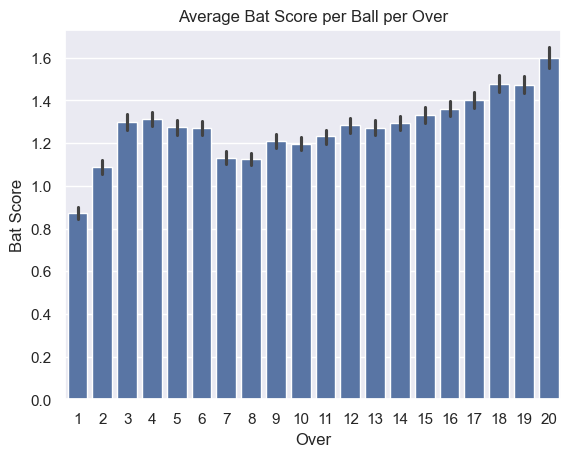

In [56]:
ax = sns.barplot(pred_df.loc[pred_df['MatchInnings']<=2],x='Over',y='Bat Score')
ax.set_title('Average Bat Score per Ball per Over')

Text(0.5, 1.0, 'Average xR per Ball per Over')

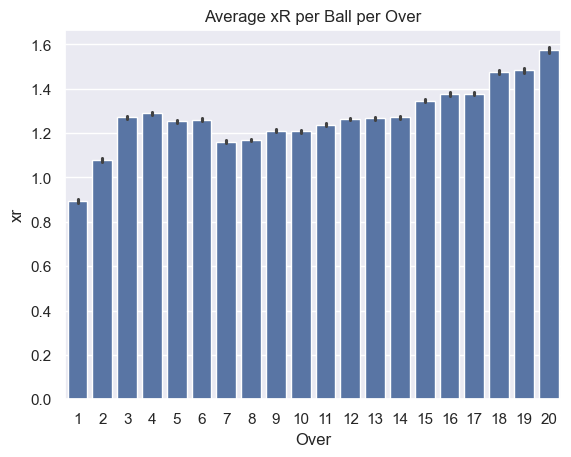

In [57]:
ax = sns.barplot(pred_df.loc[pred_df['MatchInnings']<=2],x='Over',y='xr')
ax.set_title('Average xR per Ball per Over')

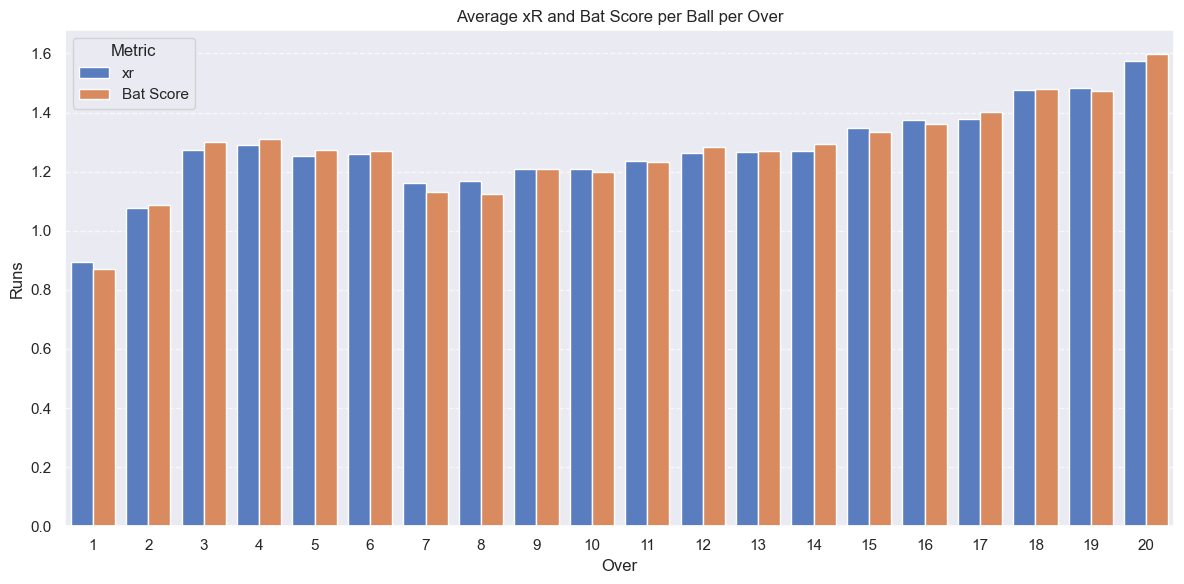

In [58]:
# Aggregate by Over
aggregated_df = pred_df.groupby("Over").agg({"xr": "mean", "Bat Score": "mean"}).reset_index()

# Reshape with melt for plotting
melted_df = aggregated_df.melt(id_vars="Over", value_vars=["xr", "Bat Score"],
                                var_name="Metric", value_name="Value")

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x="Over", y="Value", hue="Metric", palette="muted")

# Add labels and title
plt.xlabel("Over")
plt.ylabel("Runs")
plt.title("Average xR and Bat Score per Ball per Over")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

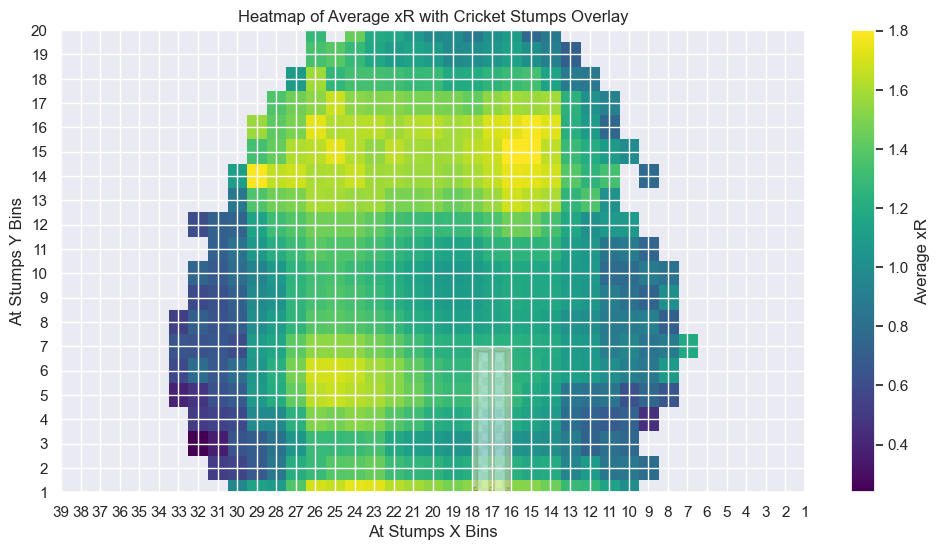

In [59]:
from PIL import Image
import numpy as np

# Group by bins and calculate average Runs Scored
grouped_df = pred_df.groupby(["At Stumps X Bins", "At Stumps Y Bins"]).agg({'xr':'mean','Over':'count'}).reset_index()

grouped_df.loc[grouped_df['Over']<=10,'xr'] = np.nan

# Pivot to create a heatmap-ready format
heatmap_data = grouped_df.pivot(
    index="At Stumps Y Bins", 
    columns="At Stumps X Bins", 
    values="xr"
)

# Load the stumps image
stumps_image_path = r"C:\Users\anude\Desktop\Jupyter Notebook Projects\Cricket NSW\Data\stumps.png" # Replace with your stumps image path
stumps_image = Image.open(stumps_image_path)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 6))
heatmap = ax.imshow(
    heatmap_data, 
    cmap="viridis", 
    origin="lower", 
    extent=[0.5, heatmap_data.shape[1] + 0.5, 0.5, heatmap_data.shape[0] + 0.5]
)

# Add colorbar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label("Average xR")

# Overlay the stumps image
# Adjust the position and size of the stumps
stumps_extent = [16, 18, 1, 7]  # [x_min, x_max, y_min, y_max]
ax.imshow(stumps_image, aspect="auto", extent=stumps_extent, alpha=0.55)

# Reverse the X-axis
ax.invert_xaxis()

# Add labels and titles
ax.set_title("Heatmap of Average xR with Cricket Stumps Overlay")
ax.set_xlabel("At Stumps X Bins")
ax.set_ylabel("At Stumps Y Bins")

# Customize ticks
ax.set_xticks(range(1, heatmap_data.shape[1] + 1))
ax.set_yticks(range(1, heatmap_data.shape[0] + 1))

plt.show()


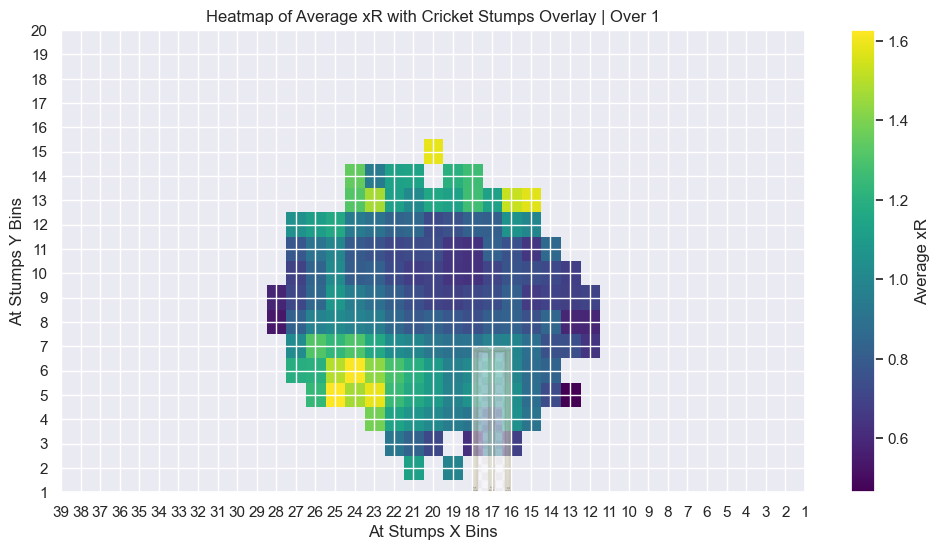

In [60]:
from PIL import Image
import numpy as np

# Group by bins and calculate average Runs Scored
grouped_df = pred_df.loc[pred_df['Over']==1].groupby(["At Stumps X Bins", "At Stumps Y Bins"]).agg({'xr':'mean','Over':'count'}).reset_index()

grouped_df.loc[grouped_df['Over']<=10,'xr'] = np.nan

# Pivot to create a heatmap-ready format
heatmap_data = grouped_df.pivot(
    index="At Stumps Y Bins", 
    columns="At Stumps X Bins", 
    values="xr"
)

# Load the stumps image
stumps_image_path = r"C:\Users\anude\Desktop\Jupyter Notebook Projects\Cricket NSW\Data\stumps.png" # Replace with your stumps image path
stumps_image = Image.open(stumps_image_path)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 6))
heatmap = ax.imshow(
    heatmap_data, 
    cmap="viridis", 
    origin="lower", 
    extent=[0.5, heatmap_data.shape[1] + 0.5, 0.5, heatmap_data.shape[0] + 0.5]
)

# Add colorbar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label("Average xR")

# Overlay the stumps image
# Adjust the position and size of the stumps
stumps_extent = [16, 18, 1, 7]  # [x_min, x_max, y_min, y_max]
ax.imshow(stumps_image, aspect="auto", extent=stumps_extent, alpha=0.55)

# Reverse the X-axis
ax.invert_xaxis()

# Add labels and titles
ax.set_title("Heatmap of Average xR with Cricket Stumps Overlay | Over 1")
ax.set_xlabel("At Stumps X Bins")
ax.set_ylabel("At Stumps Y Bins")

# Customize ticks
ax.set_xticks(range(1, heatmap_data.shape[1] + 1))
ax.set_yticks(range(1, heatmap_data.shape[0] + 1))

plt.show()


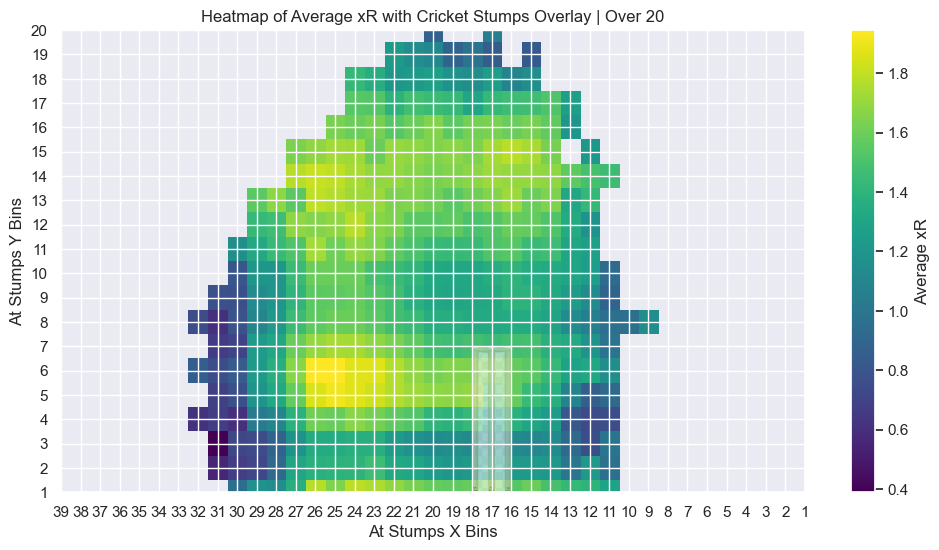

In [61]:
from PIL import Image
import numpy as np

# Group by bins and calculate average Runs Scored
grouped_df = pred_df.loc[pred_df['Over']>=16].groupby(["At Stumps X Bins", "At Stumps Y Bins"]).agg({'xr':'mean','Over':'count'}).reset_index()

grouped_df.loc[grouped_df['Over']<=10,'xr'] = np.nan

# Pivot to create a heatmap-ready format
heatmap_data = grouped_df.pivot(
    index="At Stumps Y Bins", 
    columns="At Stumps X Bins", 
    values="xr"
)

# Load the stumps image
stumps_image_path = r"C:\Users\anude\Desktop\Jupyter Notebook Projects\Cricket NSW\Data\stumps.png" # Replace with your stumps image path
stumps_image = Image.open(stumps_image_path)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 6))
heatmap = ax.imshow(
    heatmap_data, 
    cmap="viridis", 
    origin="lower", 
    extent=[0.5, heatmap_data.shape[1] + 0.5, 0.5, heatmap_data.shape[0] + 0.5]
)

# Add colorbar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label("Average xR")

# Overlay the stumps image
# Adjust the position and size of the stumps
stumps_extent = [16, 18, 1, 7]  # [x_min, x_max, y_min, y_max]
ax.imshow(stumps_image, aspect="auto", extent=stumps_extent, alpha=0.55)

# Reverse the X-axis
ax.invert_xaxis()

# Add labels and titles
ax.set_title("Heatmap of Average xR with Cricket Stumps Overlay | Over 20")
ax.set_xlabel("At Stumps X Bins")
ax.set_ylabel("At Stumps Y Bins")

# Customize ticks
ax.set_xticks(range(1, heatmap_data.shape[1] + 1))
ax.set_yticks(range(1, heatmap_data.shape[0] + 1))

plt.show()


In [85]:
pred_df.loc[
(pred_df['At Stumps X']>1100)
, 'Impact Location'
] = 'Off Side Wide'

pred_df.loc[
(pred_df['At Stumps Y'] <= 720)
& (pred_df['At Stumps X']>=-115)
& (pred_df['At Stumps X']<=115)
, 'Impact Location'
] = 'Stumps'

pred_df.loc[
(pred_df['At Stumps Y'] <= 150)
& (pred_df['At Stumps X']>=-115)
& (pred_df['At Stumps X']<=115)
, 'Impact Location'
] = 'Yorker, Stumps'

pred_df.loc[
(pred_df['At Stumps Y Bins'] >= 16)
& (pred_df['At Stumps X']>=-115)
& (pred_df['At Stumps X']<=115)
, 'Impact Location'
] = 'Bouncer, Stumps'

pred_df.loc[
(pred_df['At Stumps Y'] <= 150)
& (pred_df['At Stumps X']>=115)
& (pred_df['At Stumps X']<=1100)
, 'Impact Location'
] = 'Yorker, Outside Off Stump'

pred_df.loc[
(pred_df['At Stumps Y Bins'] >= 16)
& (pred_df['At Stumps X']>=115)
& (pred_df['At Stumps X']<=1100)
, 'Impact Location'
] = 'Bouncer, Wide'

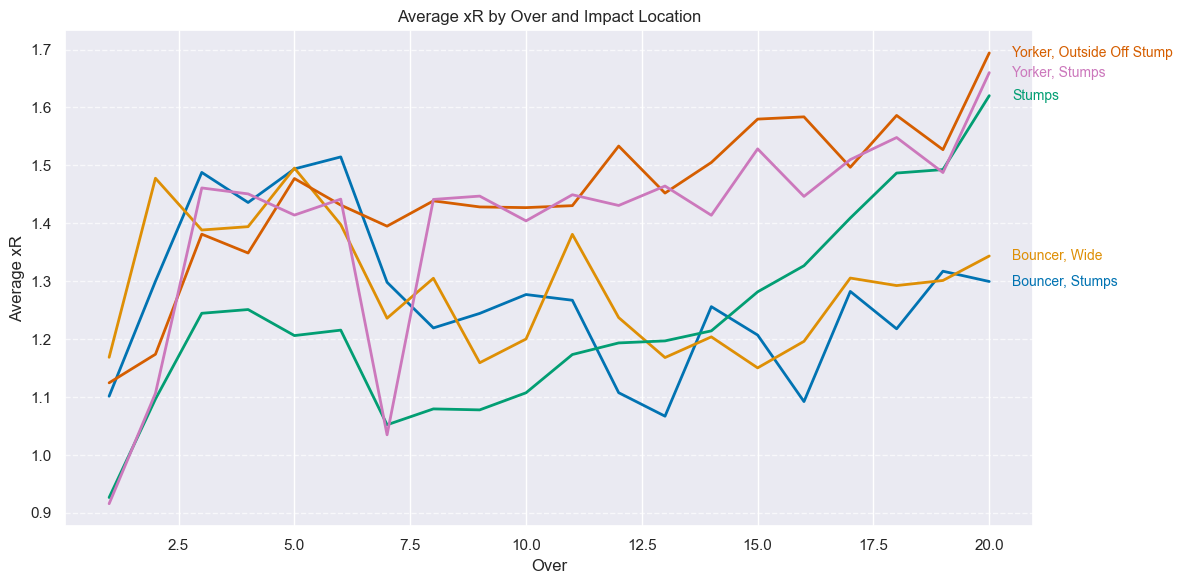

In [90]:
# Group the data by 'Over' and 'Impact Location', and calculate the mean xw
grouped_df = pred_df.loc[~pred_df['Impact Location'].isin(['Off Side Wide'])].groupby(['Over', 'Impact Location']).agg({'xr': 'mean'}).reset_index()

# Create the line plot using the colorblind palette
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_df,
    x='Over',
    y='xr',
    hue='Impact Location',
    palette='colorblind',
    linewidth=2,
    legend=False
)

# Add labels and title
plt.xlabel("Over")
plt.ylabel("Average xR")
plt.title("Average xR by Over and Impact Location")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Label each line at its endpoint
for impact_location, data in grouped_df.groupby("Impact Location"):
    # Find the last point for each line
    last_over = data["Over"].max()
    last_xw = data[data["Over"] == last_over]["xr"].values[0]
    plt.text(
        x=last_over + 0.5,  # Offset to the right
        y=last_xw,
        s=impact_location,  # Use Impact Location as the label
        color=sns.color_palette("colorblind")[grouped_df["Impact Location"].unique().tolist().index(impact_location)],
        fontsize=10,
        va="center"
    )

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [103]:
bowler_df = pred_df\
                .groupby(
                    ['Bowler']
                )\
                .agg(
                    {
                        "Bat Score":"sum"
                        ,"xr":"sum"
                        ,'Over':'count'
                    }
                )\
                .rename(
                    columns = {
                        'Over':'Deliveries Bowled'
                    }
                )\
                .reset_index()

bowler_df['bat_score/xr'] = bowler_df['Bat Score']/bowler_df['xr']

In [104]:
bowler_df\
.loc[bowler_df['Deliveries Bowled']>100]\
.sort_values(by='bat_score/xr')

,Bowler,Bat Score,xr,Deliveries Bowled,bat_score/xr
393,"Muzaurabani, Blessing",111,159.211243,119,0.697187
665,"van Meekeren, Paul Adriaan",275,383.664337,295,0.716772
48,"Baartman, Ottneil Emile Graham",244,335.647461,244,0.726953
77,"Bumrah, Jasprit",638,858.712158,723,0.742973
35,"Amir, Mohammad",382,493.848785,389,0.773516
223,"Hooda, Deepak",97,124.295723,108,0.780397
298,"Klaassen, Frederick",314,394.754242,335,0.795432
619,"Viyaskanth, Vijayakantha",137,171.357513,139,0.799498
157,"Erasmus, Gerhard",186,232.510986,189,0.799962
292,"Khan, Zahoor",195,243.451141,178,0.800982


In [105]:
batter_df = pred_df\
                .groupby(
                    ['Striker']
                )\
                .agg(
                    {
                        "Bat Score":"sum"
                        ,"xr":"sum"
                        ,'Over':'count'
                    }
                )\
                .rename(
                    columns = {
                        'Over':'Deliveries Faced'
                    }
                )\
                .reset_index()

batter_df['bat_score/xr'] = batter_df['Bat Score']/batter_df['xr']

In [107]:
batter_df.loc[batter_df['Deliveries Faced']>=100].sort_values(by='bat_score/xr',ascending=False)

,Striker,Bat Score,xr,Deliveries Faced,bat_score/xr
731,"Sharma, Abhishek",494,315.518433,289,1.565677
304,"Head, Travis",1260,926.437744,780,1.360048
602,"Patidar, Rajat",287,212.141144,170,1.352873
348,"Jaiswal, Yashasvi",412,307.792938,267,1.338562
41,"Allen, Finnley Hugh",843,635.703308,559,1.326090
898,"Yadav, Suryakumar",2847,2161.448242,1722,1.317172
913,"du Plessis, Faf",1648,1269.479492,1035,1.298170
741,"Shaw, Prithvi",295,228.329010,200,1.291995
772,"Singh, Shashank",278,216.855652,167,1.281959
767,"Singh, Prabhsimran",521,412.630157,345,1.262632


In [33]:
batter_df.loc[batter_df['Striker']=='Kohli, Virat']

,Striker,Bat Score,xr,Deliveries Faced,bat_score/xr
421,"Kohli, Virat",2426,2204.003174,1793,1.100724


<Axes: xlabel='Bat Score', ylabel='xr'>

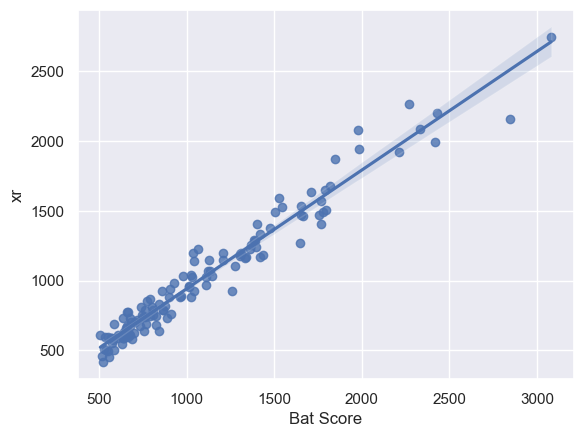

In [34]:
sns.regplot(batter_df.loc[batter_df['Bat Score']>500],x='Bat Score',y='xr')

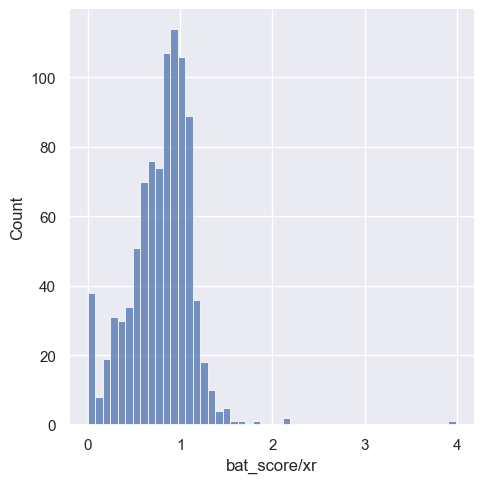

In [35]:
sns.displot(batter_df['bat_score/xr'])

In [36]:
batter_df['Strike Rate'] = (batter_df['Bat Score']/batter_df['Deliveries Faced'])*100
batter_df['xSR'] = (batter_df['xr']/batter_df['Deliveries Faced'])*100

<Axes: xlabel='bat_score/xr', ylabel='Strike Rate'>

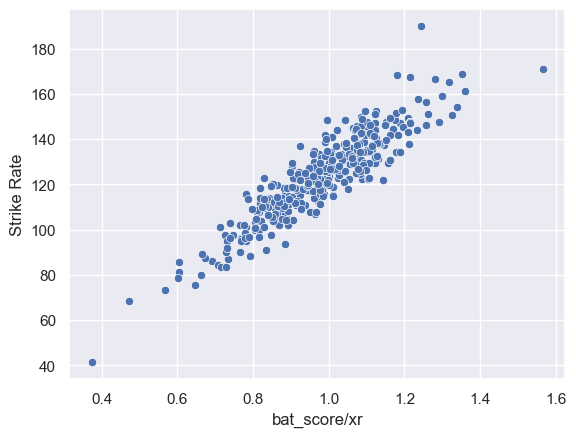

In [37]:
sns.scatterplot(batter_df.loc[batter_df['Deliveries Faced']>=100],x='bat_score/xr',y='Strike Rate')